In [ ]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np

import os

In [2]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

batch_size = 32
epochs = 25

Dataset directories path 

In [3]:
import os

base_dir = "Dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")

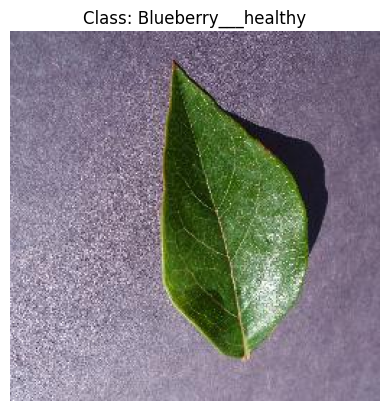

In [4]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

sample_dir = os.path.join(train_dir, random.choice(os.listdir(train_dir)))
sample_img_path = os.path.join(sample_dir, random.choice(os.listdir(sample_dir)))
image = Image.open(sample_img_path)

plt.imshow(image)
plt.title(f"Class: {os.path.basename(sample_dir)}")
plt.axis('off')
plt.show()


Data Cleaning & Preprocessing


In [ ]:
import os
from PIL import Image

def check_and_count_images(directory):
    total = 0
    corrupt = 0
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = Image.open(img_path)
                    img.verify()
                    total += 1
                except Exception:
                    corrupt += 1
    print(f"Total images checked: {total}")
    print(f"Corrupt images found: {corrupt}")

check_and_count_images(train_dir)
check_and_count_images(valid_dir)


Total images checked: 70295
Corrupt images found: 0
Total images checked: 17572
Corrupt images found: 0


In [6]:
import os
from PIL import Image

corrupt_files = []

def check_and_list_corrupt_images(directory):
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = Image.open(img_path)
                    img.verify()
                except Exception:
                    corrupt_files.append(img_path)

check_and_list_corrupt_images(train_dir)
print("Corrupt files found:", corrupt_files)


Corrupt files found: []


## Data Augmentation & Loading


Set Up ImageDataGenerator

In [9]:
from tensorflow import keras

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode="nearest"
)

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0
)


Load Data from Directories

In [10]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),         # match your MobileNet input
    batch_size=32,
    class_mode="categorical"
)

valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


 visualize augmented sample

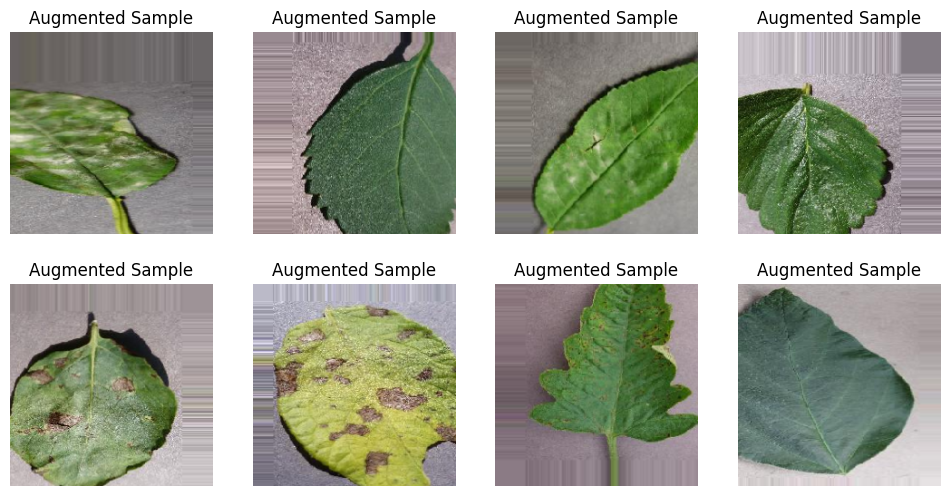

In [11]:
import matplotlib.pyplot as plt

# Get a batch of images and labels from the data generator
images, labels = next(train_data)

# Plot the first 8 images in the batch
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title("Augmented Sample")
plt.show()


## Model Architecture

In [12]:
import tensorflow as tf
from tensorflow import keras

base_model = tf.keras.applications.MobileNet(weights="imagenet",
                                             include_top=False,
                                             input_shape=(224, 224, 3))
base_model.trainable = False  # For initial training

inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(train_data.num_classes, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=x, name="LeafDisease_MobileNet")


Compile the Model

In [13]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy(), 'accuracy'])


Model Training


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

# Define callbacks for early stopping and saving best model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Train the model
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=50,                  # set as needed
    steps_per_epoch=150,        # adjust based on dataset size
    validation_steps=100,       # adjust based on dataset size
    callbacks=callbacks
)

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.2862 - categorical_accuracy: 0.2862 - loss: 2.8674

150/150 ━━━━━━━━━━━━━━━━━━━━ 111s 730ms/step - accuracy: 0.4867 - categorical_accuracy: 0.4867 - loss: 1.9673 - val_accuracy: 0.7956 - val_categorical_accuracy: 0.7956 - val_loss: 0.8132
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.7638 - categorical_accuracy: 0.7638 - loss: 0.8945

150/150 ━━━━━━━━━━━━━━━━━━━━ 109s 727ms/step - accuracy: 0.7898 - categorical_accuracy: 0.7898 - loss: 0.7686 - val_accuracy: 0.8656 - val_categorical_accuracy: 0.8656 - val_loss: 0.5128
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.8286 - categorical_accuracy: 0.8286 - loss: 0.6011

150/150 ━━━━━━━━━━━━━━━━━━━━ 108s 722ms/step - accuracy: 0.8390 - categorical_accuracy: 0.8390 - loss: 0.5567 - val_accuracy: 0.8953 - val_categorical_accuracy: 0.8953 - val_loss: 0.3781
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.8575 - categorical_accuracy: 0.8575 - loss: 0.4808

150/150 ━━━━━━━━━━━━━━━━━━━━ 107s 719ms/step - accuracy: 0.8644 - categorical_accuracy: 0.8644 - loss: 0.4588 - val_accuracy: 0.8978 - val_categorical_accuracy: 0.8978 - val_loss: 0.3412
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.8707 - categorical_accuracy: 0.8707 - loss: 0.4105

150/150 ━━━━━━━━━━━━━━━━━━━━ 105s 704ms/step - accuracy: 0.8792 - categorical_accuracy: 0.8792 - loss: 0.4058 - val_accuracy: 0.9100 - val_categorical_accuracy: 0.9100 - val_loss: 0.2967
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8748 - categorical_accuracy: 0.8748 - loss: 0.3973

150/150 ━━━━━━━━━━━━━━━━━━━━ 103s 687ms/step - accuracy: 0.8806 - categorical_accuracy: 0.8806 - loss: 0.3786 - val_accuracy: 0.9116 - val_categorical_accuracy: 0.9116 - val_loss: 0.2934
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8961 - categorical_accuracy: 0.8961 - loss: 0.3351

150/150 ━━━━━━━━━━━━━━━━━━━━ 116s 777ms/step - accuracy: 0.8933 - categorical_accuracy: 0.8933 - loss: 0.3411 - val_accuracy: 0.9319 - val_categorical_accuracy: 0.9319 - val_loss: 0.2281
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 132s 886ms/step - accuracy: 0.9052 - categorical_accuracy: 0.9052 - loss: 0.3090 - val_accuracy: 0.9294 - val_categorical_accuracy: 0.9294 - val_loss: 0.2388
Epoch 9/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.9135 - categorical_accuracy: 0.9135 - loss: 0.2894

150/150 ━━━━━━━━━━━━━━━━━━━━ 121s 810ms/step - accuracy: 0.9133 - categorical_accuracy: 0.9133 - loss: 0.2891 - val_accuracy: 0.9344 - val_categorical_accuracy: 0.9344 - val_loss: 0.2192
Epoch 10/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 121s 809ms/step - accuracy: 0.9008 - categorical_accuracy: 0.9008 - loss: 0.3034 - val_accuracy: 0.9259 - val_categorical_accuracy: 0.9259 - val_loss: 0.2279
Epoch 11/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.9113 - categorical_accuracy: 0.9113 - loss: 0.2875

150/150 ━━━━━━━━━━━━━━━━━━━━ 120s 801ms/step - accuracy: 0.9033 - categorical_accuracy: 0.9033 - loss: 0.2942 - val_accuracy: 0.9275 - val_categorical_accuracy: 0.9275 - val_loss: 0.2113
Epoch 12/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.9113 - categorical_accuracy: 0.9113 - loss: 0.2731

150/150 ━━━━━━━━━━━━━━━━━━━━ 119s 795ms/step - accuracy: 0.9169 - categorical_accuracy: 0.9169 - loss: 0.2563 - val_accuracy: 0.9356 - val_categorical_accuracy: 0.9356 - val_loss: 0.2067
Epoch 13/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9209 - categorical_accuracy: 0.9209 - loss: 0.2527

150/150 ━━━━━━━━━━━━━━━━━━━━ 125s 838ms/step - accuracy: 0.9179 - categorical_accuracy: 0.9179 - loss: 0.2589 - val_accuracy: 0.9388 - val_categorical_accuracy: 0.9388 - val_loss: 0.1916
Epoch 14/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 141s 943ms/step - accuracy: 0.9121 - categorical_accuracy: 0.9121 - loss: 0.2620 - val_accuracy: 0.9350 - val_categorical_accuracy: 0.9350 - val_loss: 0.2030
Epoch 15/50
 97/150 ━━━━━━━━━━━━━━━━━━━━ 21s 398ms/step - accuracy: 0.9309 - categorical_accuracy: 0.9309 - loss: 0.2354

E:\vijay\Agribazaar_AI\agri_gpu_env\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 73s 489ms/step - accuracy: 0.9259 - categorical_accuracy: 0.9259 - loss: 0.2360 - val_accuracy: 0.9344 - val_categorical_accuracy: 0.9344 - val_loss: 0.2080
Epoch 16/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.9224 - categorical_accuracy: 0.9224 - loss: 0.2420

150/150 ━━━━━━━━━━━━━━━━━━━━ 133s 885ms/step - accuracy: 0.9202 - categorical_accuracy: 0.9202 - loss: 0.2485 - val_accuracy: 0.9378 - val_categorical_accuracy: 0.9378 - val_loss: 0.1875
Epoch 17/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 141s 942ms/step - accuracy: 0.9242 - categorical_accuracy: 0.9242 - loss: 0.2443 - val_accuracy: 0.9375 - val_categorical_accuracy: 0.9375 - val_loss: 0.1935
Epoch 18/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 142s 950ms/step - accuracy: 0.9250 - categorical_accuracy: 0.9250 - loss: 0.2337 - val_accuracy: 0.9366 - val_categorical_accuracy: 0.9366 - val_loss: 0.1922
Epoch 19/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.9209 - categorical_accuracy: 0.9209 - loss: 0.2367

150/150 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9217 - categorical_accuracy: 0.9217 - loss: 0.2321 - val_accuracy: 0.9491 - val_categorical_accuracy: 0.9491 - val_loss: 0.1627
Epoch 20/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.9261 - categorical_accuracy: 0.9261 - loss: 0.2237 - val_accuracy: 0.9431 - val_categorical_accuracy: 0.9431 - val_loss: 0.1721
Epoch 21/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 130s 874ms/step - accuracy: 0.9321 - categorical_accuracy: 0.9321 - loss: 0.2156 - val_accuracy: 0.9419 - val_categorical_accuracy: 0.9419 - val_loss: 0.1642
Epoch 22/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.9304 - categorical_accuracy: 0.9304 - loss: 0.2182

150/150 ━━━━━━━━━━━━━━━━━━━━ 128s 858ms/step - accuracy: 0.9287 - categorical_accuracy: 0.9287 - loss: 0.2179 - val_accuracy: 0.9516 - val_categorical_accuracy: 0.9516 - val_loss: 0.1456
Epoch 23/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 853ms/step - accuracy: 0.9306 - categorical_accuracy: 0.9306 - loss: 0.2100 - val_accuracy: 0.9484 - val_categorical_accuracy: 0.9484 - val_loss: 0.1715
Epoch 24/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 127s 850ms/step - accuracy: 0.9394 - categorical_accuracy: 0.9394 - loss: 0.1998 - val_accuracy: 0.9472 - val_categorical_accuracy: 0.9472 - val_loss: 0.1580
Epoch 25/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 122s 814ms/step - accuracy: 0.9308 - categorical_accuracy: 0.9308 - loss: 0.2003 - val_accuracy: 0.9400 - val_categorical_accuracy: 0.9400 - val_loss: 0.1705
Epoch 26/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.9223 - categorical_accuracy: 0.9223 - loss: 0.2246

150/150 ━━━━━━━━━━━━━━━━━━━━ 121s 808ms/step - accuracy: 0.9252 - categorical_accuracy: 0.9252 - loss: 0.2234 - val_accuracy: 0.9559 - val_categorical_accuracy: 0.9559 - val_loss: 0.1386
Epoch 27/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 119s 795ms/step - accuracy: 0.9354 - categorical_accuracy: 0.9354 - loss: 0.1903 - val_accuracy: 0.9456 - val_categorical_accuracy: 0.9456 - val_loss: 0.1617
Epoch 28/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 117s 784ms/step - accuracy: 0.9337 - categorical_accuracy: 0.9337 - loss: 0.2050 - val_accuracy: 0.9444 - val_categorical_accuracy: 0.9444 - val_loss: 0.1599
Epoch 29/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 116s 776ms/step - accuracy: 0.9344 - categorical_accuracy: 0.9344 - loss: 0.2017 - val_accuracy: 0.9494 - val_categorical_accuracy: 0.9494 - val_loss: 0.1466
Epoch 30/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 142s 948ms/step - accuracy: 0.9391 - categorical_accuracy: 0.9391 - loss: 0.1802 - val_accuracy: 0.9503 - val_categorical_accuracy: 0.9503 - val_loss: 0.1585
Epoch 31/50
150/1

150/150 ━━━━━━━━━━━━━━━━━━━━ 118s 793ms/step - accuracy: 0.9340 - categorical_accuracy: 0.9340 - loss: 0.2016 - val_accuracy: 0.9600 - val_categorical_accuracy: 0.9600 - val_loss: 0.1298
Epoch 33/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 119s 796ms/step - accuracy: 0.9310 - categorical_accuracy: 0.9310 - loss: 0.2014 - val_accuracy: 0.9503 - val_categorical_accuracy: 0.9503 - val_loss: 0.1479
Epoch 34/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 115s 769ms/step - accuracy: 0.9262 - categorical_accuracy: 0.9262 - loss: 0.2042 - val_accuracy: 0.9519 - val_categorical_accuracy: 0.9519 - val_loss: 0.1422
Epoch 35/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 111s 740ms/step - accuracy: 0.9340 - categorical_accuracy: 0.9340 - loss: 0.1988 - val_accuracy: 0.9503 - val_categorical_accuracy: 0.9503 - val_loss: 0.1597
Epoch 36/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 114s 762ms/step - accuracy: 0.9377 - categorical_accuracy: 0.9377 - loss: 0.1866 - val_accuracy: 0.9488 - val_categorical_accuracy: 0.9488 - val_loss: 0.1450
Epoch 37/50
150/1

150/150 ━━━━━━━━━━━━━━━━━━━━ 106s 711ms/step - accuracy: 0.9386 - categorical_accuracy: 0.9386 - loss: 0.1826 - val_accuracy: 0.9578 - val_categorical_accuracy: 0.9578 - val_loss: 0.1255
Epoch 44/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 106s 707ms/step - accuracy: 0.9417 - categorical_accuracy: 0.9417 - loss: 0.1806 - val_accuracy: 0.9559 - val_categorical_accuracy: 0.9559 - val_loss: 0.1392
Epoch 45/50
 97/150 ━━━━━━━━━━━━━━━━━━━━ 24s 468ms/step - accuracy: 0.9338 - categorical_accuracy: 0.9338 - loss: 0.1983

150/150 ━━━━━━━━━━━━━━━━━━━━ 81s 543ms/step - accuracy: 0.9317 - categorical_accuracy: 0.9317 - loss: 0.1984 - val_accuracy: 0.9588 - val_categorical_accuracy: 0.9588 - val_loss: 0.1251
Epoch 46/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 110s 738ms/step - accuracy: 0.9388 - categorical_accuracy: 0.9388 - loss: 0.1842 - val_accuracy: 0.9556 - val_categorical_accuracy: 0.9556 - val_loss: 0.1377
Epoch 47/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 110s 733ms/step - accuracy: 0.9350 - categorical_accuracy: 0.9350 - loss: 0.1993 - val_accuracy: 0.9553 - val_categorical_accuracy: 0.9553 - val_loss: 0.1287
Epoch 48/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 109s 731ms/step - accuracy: 0.9348 - categorical_accuracy: 0.9348 - loss: 0.1873 - val_accuracy: 0.9522 - val_categorical_accuracy: 0.9522 - val_loss: 0.1348
Epoch 49/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.9281 - categorical_accuracy: 0.9281 - loss: 0.2163

150/150 ━━━━━━━━━━━━━━━━━━━━ 142s 950ms/step - accuracy: 0.9325 - categorical_accuracy: 0.9325 - loss: 0.1913 - val_accuracy: 0.9647 - val_categorical_accuracy: 0.9647 - val_loss: 0.1157
Epoch 50/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 107s 716ms/step - accuracy: 0.9400 - categorical_accuracy: 0.9400 - loss: 0.1795 - val_accuracy: 0.9556 - val_categorical_accuracy: 0.9556 - val_loss: 0.1222


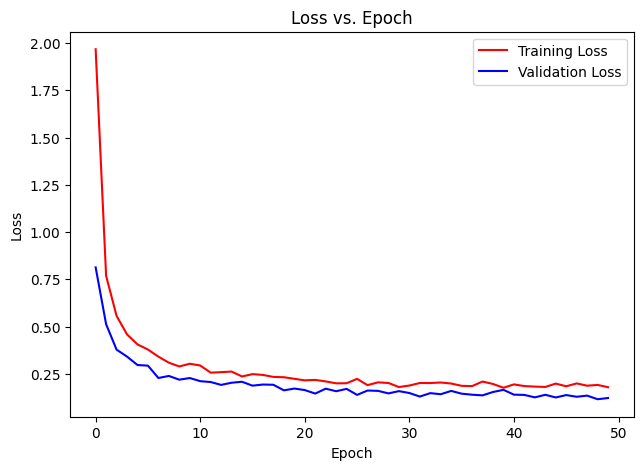

In [15]:
plt.figure(figsize=(16, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', c='red')
plt.plot(history.history['val_loss'], label='Validation Loss', c='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

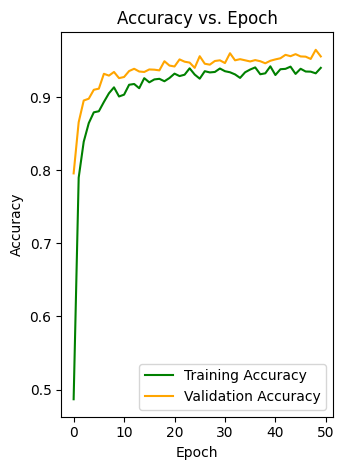

In [16]:
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', c='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', c='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
!pip install scikit-learn


   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.9 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/8.9 MB 3.9 MB/s eta 0:00:03
   ------- -------------------------------- 1.6/8.9 MB 4.0 MB/s eta 0:00:02
   ----------- ---------------------------- 2.6/8.9 MB 3.7 MB/s eta 0:00:02
   --------------- ------------------------ 3.4/8.9 MB 3.8 MB/s eta 0:00:02
   ------------------ --------------------- 4.2/8.9 MB 3.8 MB/s eta 0:00:02
   ---------------------- ----------------- 5.0/8.9 MB 3.9 MB/s eta 0:00:02
   ------------------------- -------------- 5.8/8.9 MB 3.8 MB/s eta 0:00:01
   ----------------------------- ---------- 6.6/8.9 MB 3.8 MB/s eta 0:00:01
   ----------------------------- ---------- 6.6/8.9 MB 3.8 MB/s eta 0:00:01
   ------------------------------------ --- 8.1/8.9 MB 3.9 MB/s eta 0:00:01
   -------------------------------------- - 8.7/8.9 MB 3.8 MB/s eta 0:00:01
   -----------------------

In [27]:
valid_data_for_eval = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0).flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 17572 images belonging to 38 classes.


In [33]:
import numpy as np
from sklearn.metrics import classification_report

pred_probs = model.predict(valid_data_for_eval, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = valid_data_for_eval.classes

print(classification_report(y_true, y_pred, target_names=list(valid_data_for_eval.class_indices.keys())))


550/550 ━━━━━━━━━━━━━━━━━━━━ 175s 318ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.95      0.97       504
                                 Apple___Black_rot       0.97      0.99      0.98       497
                          Apple___Cedar_apple_rust       1.00      0.98      0.99       440
                                   Apple___healthy       0.96      0.98      0.97       502
                               Blueberry___healthy       1.00      0.98      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      1.00       421
                 Cherry_(including_sour)___healthy       0.98      1.00      0.99       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.86      0.91       410
                       Corn_(maize)___Common_rust_       0.98      1.00      0.99       477
               Corn_(maize)___Nort

Save the final model in both Keras and TFLite formats

In [38]:
model.save('plant_disease_model.keras')


In [39]:
model.save('plant_disease_model.h5')


Convert to TFLite and save

In [40]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('plant_disease_model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\Hp\AppData\Local\Temp\tmp0e172p4z\assets


INFO:tensorflow:Assets written to: C:\Users\Hp\AppData\Local\Temp\tmp0e172p4z\assets


Saved artifact at 'C:\Users\Hp\AppData\Local\Temp\tmp0e172p4z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_86')
Output Type:
  TensorSpec(shape=(None, 38), dtype=tf.float32, name=None)
Captures:
  2163035288880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163035289584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163035030272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163034743456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163038439200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163035034144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163038443248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163038445360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163038441488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163038443776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163

In [41]:
from tensorflow import keras
model = keras.models.load_model('plant_disease_model.keras')  # Or .h5 if you used that


E:\vijay\Agribazaar_AI\agri_gpu_env\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
